In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# General imports
from pathlib import Path
import tifffile
import torch
import cupy as cp
import numpy as np

In [3]:
# Plotting
from matplotlib.collections import PolyCollection
from matplotlib import pyplot as plt, patches
plt.style.use('moorman')

In [4]:
data_dir = Path(
    '/data1/peerd/spatial_datalake/reyesj3_pancreas_premalignant'
    '/15-07/processed'
)
path_tiff_if = next(data_dir.glob('microscopy/*warped*.tif*'))

In [20]:
channels = [0,2,22,25,27,29,30]
im = tifffile.imread(
    path_tiff_if,
    level=-2,
)[channels].reshape(7, -1)
means = im.mean(1).astype(int)
std = im.std(1).astype(int)

Object `BasicSelection` not found.


In [22]:
std

array([ 749, 2758,  145, 1745,  494, 2105,  241])

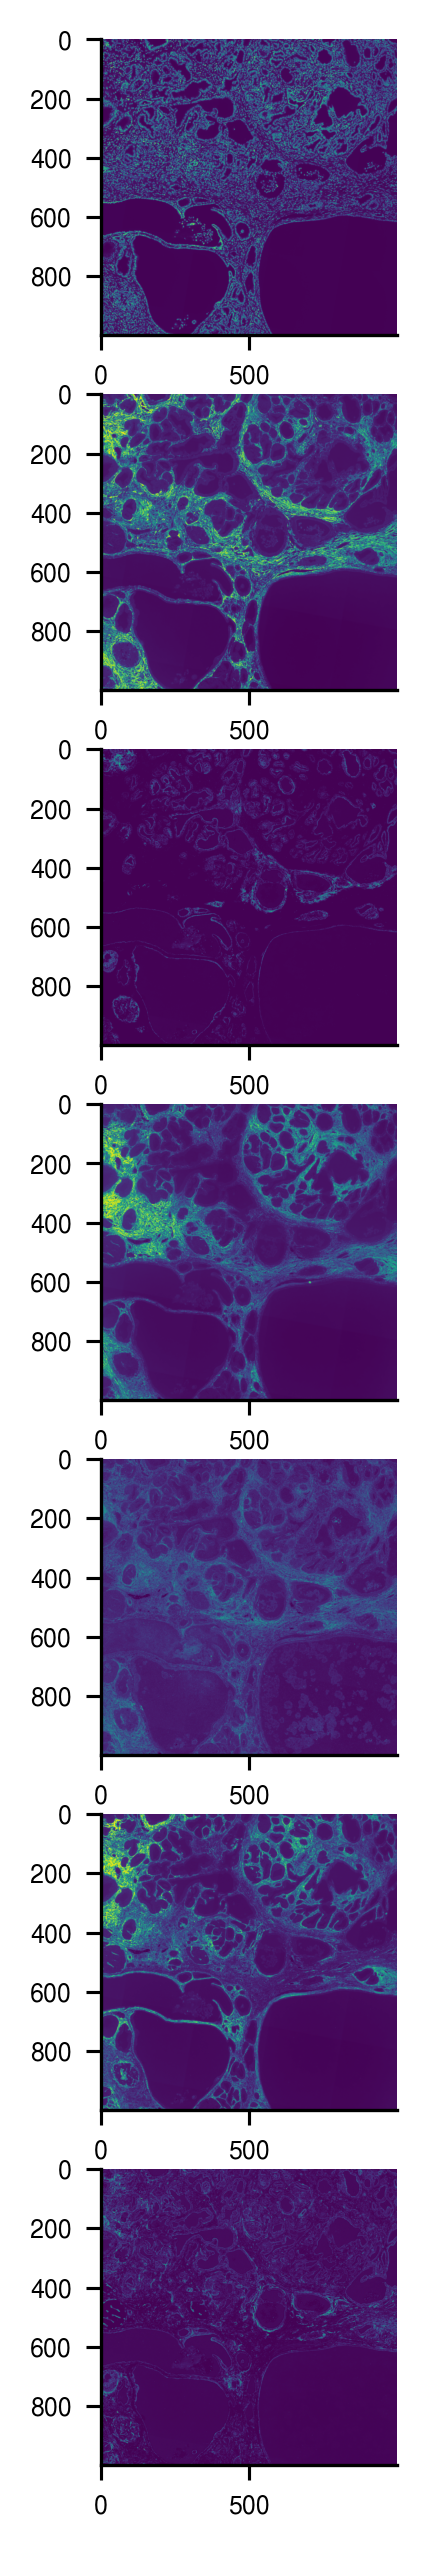

In [12]:
fig, axes = plt.subplots(7, 1, figsize=(1.5, 10.5))

for i in range(len(channels)):
    axes[i].imshow(im[i, 4500:5500, 4500:5500])

In [46]:
dinov3_path  = Path('/data1/peerd/moormana/GitHub/other/dinov3')
weights_path = Path('/data1/peerd/moormana/GitHub/andrewmoorman/fossil/weights/dinov3')
model_name = 'dinov3_vits16'
weights_path = str(next(weights_path.glob(f'*{model_name}*')))

output_path = weights_path.replace('.pth', '_dinov3_checkpoint.pth')
sd = torch.load(weights_path)
sd = {
    f'backbone.{key}': val for key, val in sd.items()
}
sd = {
    "teacher": sd
}
torch.save(sd, output_path)

In [47]:
dinov3_path  = Path('/data1/peerd/moormana/GitHub/other/dinov3')
weights_path = Path('/data1/peerd/moormana/GitHub/andrewmoorman/fossil/weights/dinov3')
model_name = 'dinov3_vits16plus'
str(next(weights_path.glob(f'*{model_name}*')))

model_name = 'dinov3_vits16plus'
model = torch.hub.load(
    dinov3_path,
    model_name,
    source='local',
    weights=str(next(weights_path.glob(f'*{model_name}*'))),
)

from dinov3.models.channel_adapter import expand_patch_embed_to_nch
model = expand_patch_embed_to_nch(model, 32)

In [48]:
from tqdm import tqdm
for i in tqdm(range(10)):
    ds[i]

100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


In [4]:
import torch
from dinov3.configs import setup_config, setup_job
from dinov3.train.ssl_meta_arch import SSLMetaArch
from dinov3.checkpointer.checkpointer import load_checkpoint
from dinov3.models.channel_adapter import retarget_patch_embed_meta

import math

# --- 1) Build the same meta-arch you trained (but on 'meta' so it's instant)
class Args: pass
args = Args()
args.config_file = "/data1/peerd/moormana/GitHub/other/dinov3/dinov3/configs/train/dinov3_vit7s16_ch32.yaml"
args.opts = []  # or CLI-style overrides if needed
args.output_dir = "."  # unused here
args.seed = 0
cfg = setup_config(args, strict_cfg=False)

# Make sure in_chans matches your 32ch setup
cfg.student.in_chans = 9
cfg.teacher.in_chans = 9

with torch.device("meta"):
    model = SSLMetaArch(cfg)

retarget_patch_embed_meta(model, in_chans=cfg.student.in_chans, patch_size=cfg.student.patch_size)
    
#model.prepare_for_distributed_training()
# Fill all values with `nans` so that we identify
# non-initialized values
model = model._apply(
    lambda t: torch.full_like(
        t,
        fill_value=math.nan if t.dtype.is_floating_point else (2 ** (t.dtype.itemsize * 8 - 1)),
        device="cuda",
    ),
    recurse=True,
)

In [5]:
ckpt = load_checkpoint(
    '/data1/peerd/moormana/GitHub/andrewmoorman/fossil/checkpoints/4/ckpt/10999',
    model=model,
    strict_loading=False,
)

/data1/peerd/moormana/.micromamba/envs/trex/lib/python3.11/site-packages/torch/distributed/checkpoint/state_dict_loader.py:153: UserWarning: torch.distributed is disabled, unavailable or uninitialized, assuming the intent is to load in a single process.
  warnings.warn(


In [51]:
from torch.distributed.tensor import DTensor

new_state_dict = model.model_ema.state_dict()
for k, tensor in list(new_state_dict.items()):
    if isinstance(tensor, DTensor):
        new_state_dict[k] = tensor.full_tensor()

eval_dir = Path('/data1/peerd/moormana/GitHub/andrewmoorman/fossil/checkpoints/4/eval')
ckpt_path = eval_dir / "teacher_checkpoint.pth"
torch.save({"teacher": new_state_dict}, ckpt_path)

In [52]:
import scanpy as sc

ad = sc.read_h5ad(
    '/data1/peerd/spatial_datalake/reyesj3_pancreas_premalignant/15-07/processed/microscopy/cellpose_v0_adata.h5ad'
)

In [53]:
ad.obs['y'].max(), ad.obs['x'].max()

(np.float64(60492.28205128205), np.float64(42650.0))

In [54]:
for x, y in tqdm(ds._mask.get_masked_coordinates(1000)):

    x = min(ds._xmax, x)
    y = min(ds._ymax, y)

    # Slice BioImage and return as Tensor
    xs = slice(x, x + ds._tile_size)
    ys = slice(y, y + ds._tile_size)
    cs = slice(None, None, None)
    image_data = tifffile.imread(
        ds._path,
        level=0,
        selection=(cs, ys, xs)
    )
    torch.tensor(image_data)

  0%|          | 0/1000 [00:00<?, ?it/s]


AttributeError: 'BioImageDataset' object has no attribute '_tile_size'

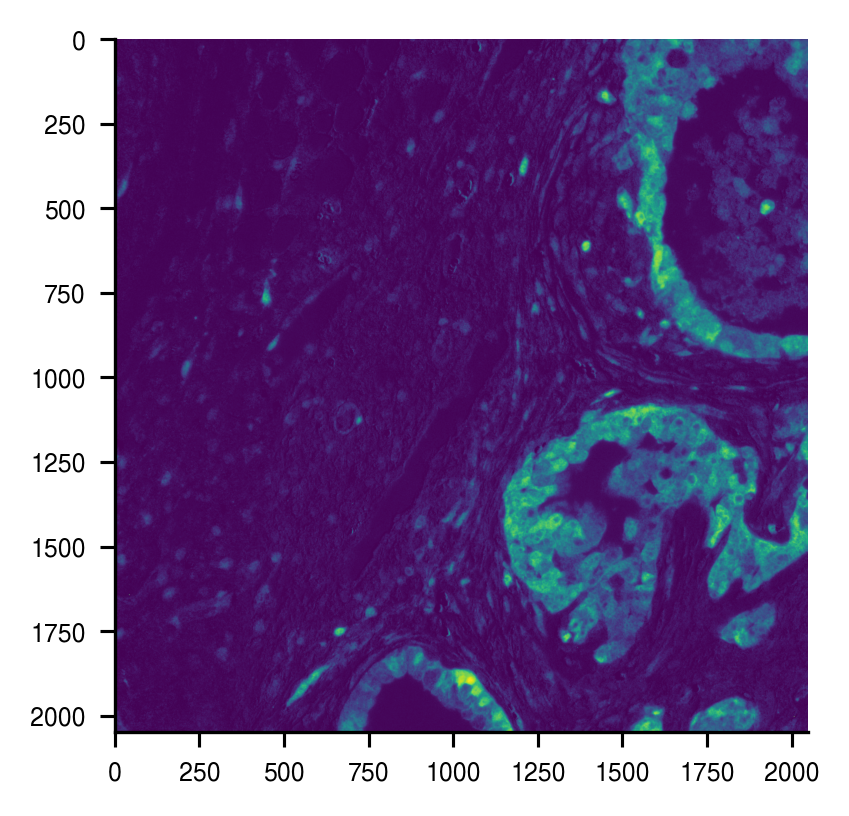

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))

ax.imshow(ds[100][1])

(153.0, 0.0)

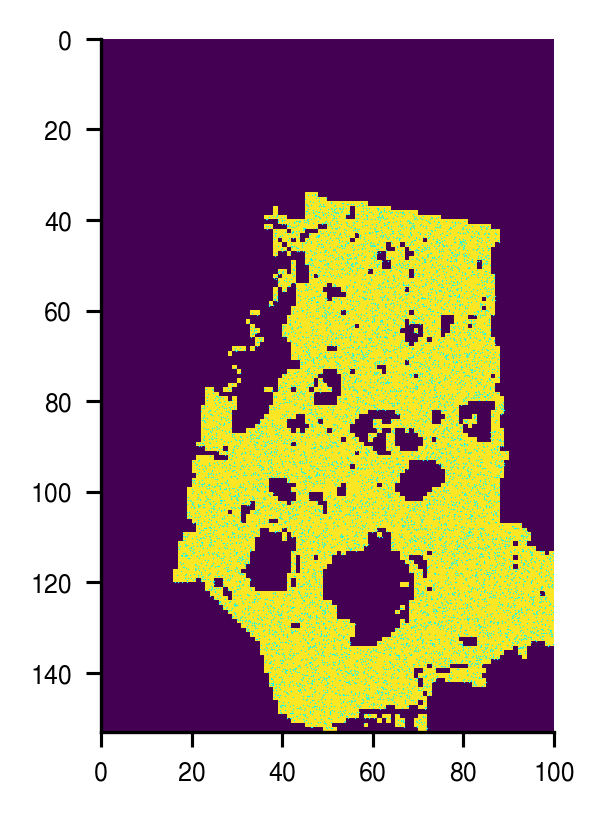

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(3,3))

# Get the dimensions of the tile mask
H, W = mask._tile_mask.shape

# Define the extent: [left, right, bottom, top]
# This tells matplotlib to draw the pixels in the correct coordinate space.
img_extent = [0, W, H , 0]

# Use the extent keyword argument
ax.imshow(mask._tile_mask, extent=img_extent)

# Your point generation logic is correct for this setup
pts = mask.get_masked_coordinates(10000) / mask._tile_size

# The scatter plot will now align perfectly with the image ✅
ax.scatter(pts[:, 0], pts[:, 1], s=.1, lw=0, c='cyan')

# Set axis limits to match the image extent for a clean plot
ax.set_xlim(img_extent[0], img_extent[1])
ax.set_ylim(img_extent[2], img_extent[3])



In [ ]:
idx = image.dims.order.index('Y')
level_dims = image.resolution_level_dims
downsample = round(level_dims[0][idx] / level_dims[5][idx])

In [ ]:
pad_width = []
for dim, b in zip(arr_shape, block_shape):
    remainder = dim % b
    extra = (b - remainder) if remainder != 0 else 0
    pad_width.append((0, extra))

In [ ]:
np.pad(mask, (0,5), constant_values=False)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]],
      shape=(2447, 1603))

In [ ]:
image.set_resolution_level(5)
image.get_image_data('CYX', C=[0,1])

array([[[6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        ...,
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6]],

       [[6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        ...,
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6]]], shape=(2, 2442, 1598), dtype=uint16)

In [ ]:
img = BioImage(tiff_path, reader=ome_tiff_reader)

2.0 2.0
2
3.999843554443054 4.0
4
7.999687108886108 8.0
8
15.999374217772216 15.998361998361998
16
31.99874843554443 31.996723996723997
32


In [ ]:
%%timeit -n 3 -r 3

img.set_resolution_level(5)
img.get_image_dask_data()

The slowest run took 4.76 times longer than the fastest. This could mean that an intermediate result is being cached.
5.97 μs ± 4.6 μs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [ ]:
img.set_resolution_level(5)
img.get_image_data("CYX", X=slice(100, 1000))

array([[[6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        ...,
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6]],

       [[6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        ...,
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6]],

       [[6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        ...,
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6]],

       ...,

       [[6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        ...,
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6]],

       [[6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        ...,
        [6, 6, 6, ..., 

In [ ]:
%%timeit -n 3 -r 3
tifffile.imread(
    tiff_path,
    level=5,
)

92.2 ms ± 774 μs per loop (mean ± std. dev. of 3 runs, 3 loops each)


array([[[[[6, 6, 6, ..., 6, 6, 6],
          [6, 6, 6, ..., 6, 6, 6],
          [6, 6, 6, ..., 6, 6, 6],
          ...,
          [6, 6, 6, ..., 6, 6, 6],
          [6, 6, 6, ..., 6, 6, 6],
          [6, 6, 6, ..., 6, 6, 6]]],


        [[[6, 6, 6, ..., 6, 6, 6],
          [6, 6, 6, ..., 6, 6, 6],
          [6, 6, 6, ..., 6, 6, 6],
          ...,
          [6, 6, 6, ..., 6, 6, 6],
          [6, 6, 6, ..., 6, 6, 6],
          [6, 6, 6, ..., 6, 6, 6]]],


        [[[6, 6, 6, ..., 6, 6, 6],
          [6, 6, 6, ..., 6, 6, 6],
          [6, 6, 6, ..., 6, 6, 6],
          ...,
          [6, 6, 6, ..., 6, 6, 6],
          [6, 6, 6, ..., 6, 6, 6],
          [6, 6, 6, ..., 6, 6, 6]]],


        ...,


        [[[6, 6, 6, ..., 6, 6, 6],
          [6, 6, 6, ..., 6, 6, 6],
          [6, 6, 6, ..., 6, 6, 6],
          ...,
          [6, 6, 6, ..., 6, 6, 6],
          [6, 6, 6, ..., 6, 6, 6],
          [6, 6, 6, ..., 6, 6, 6]]],


        [[[6, 6, 6, ..., 6, 6, 6],
          [6, 6, 6, ..., 6, 6, 6],

In [ ]:
from bioio_ome_tiff.utils import get_coords_from_ome

get_coords_from_ome(
    img.reader._ome,
    img.reader.current_scene_index,
)

{'C': ['DAPI (3)',
  'dpERK 9101 (NP) - TRITC',
  'Podoplanin (NP) - Cy5',
  'CD3e (NP) - TRITC',
  'Cytokeratin 19 (NP) - TRITC',
  'CD45 (NP) - Cy5',
  'CD11b ITGAM (NP) - TRITC',
  'Na-K ATPase (NP) - Cy5',
  'aSMA (NP) - TRITC',
  'HMGA2 (NP) - Cy5',
  'Collagen 12A1 (NP) - TRITC',
  'MSN (NP) - Cy5',
  'Thrombospondin (NP) - TRITC',
  'p53 (NP) - Cy5',
  'Collagen 18 (NP) - TRITC',
  'Vimentin CST (NP) - Cy5',
  'E-cadherin (NP) - TRITC',
  'CD11c (NP) - Cy5',
  'Galectin 4 (NP) - TRITC',
  'F4_80 (NP) - Cy5',
  'Integrin B1 (NP) - TRITC',
  'PDFGRa (NP) - Cy5',
  'Tenascin C (NP) - TRITC',
  'Tenascin X (NP) - Cy5',
  'CD31 PECAM (NP) - TRITC',
  'Collagen I (NP) - Cy5',
  'CDKN2A p16INK4a (NP) - TRITC',
  'Collagen III (NP) - Cy5',
  'p19 (NP) - TRITC',
  'Collagen VI (NP) - Cy5',
  'Collagen IV (NP) - TRITC',
  'GFP (NP) - Cy5'],
 'Y': array([0.000000e+00, 2.800000e-01, 5.600000e-01, ..., 2.187724e+04,
        2.187752e+04, 2.187780e+04], shape=(78136,)),
 'X': array([0.000000e

In [ ]:
data_dir = Path(
    '/data1/peerd/spatial_datalake/reyesj3_pancreas_premalignant'
    '/15-07/processed'
)
tiff_path = next(data_dir.glob('microscopy/*warped*.tiff'))
with tifffile.TiffFile(tiff_path, mode='r') as tf:
    tags = tf.series[0].levels[0]

In [ ]:
tags.pages[0].tags['XResolution'].value

(1, 1)

In [ ]:
tags.pages[0].tags['ImageWidth'].value

51134

In [ ]:
tf.series[0].levels[1].shape

(32, 39068, 25567)

In [ ]:
from tifffile import TiffFile
import xml.etree.ElementTree as ET
import re

_attr_rx = lambda k: re.compile(rf'({k}\s*=\s*")([^"]*)(")')

def patch_pixels_attrs(path: str | Path, updates: dict[str, str | int]) -> None:
    """
    Change attributes inside the <Pixels …> element of an OME-TIFF *in place*.

    `updates`  e.g. {"SizeX": 51134, "SizeY": 78136}

    Fails if any replacement would change the byte length.
    """
    with TiffFile(str(path), mode="r+b") as tif:
        tag = tif.pages[0].tags["ImageDescription"]
        xml = tag.value.decode("utf-8") if isinstance(tag.value, bytes) else tag.value
        new_xml = xml

        for key, val in updates.items():
            m = _attr_rx(key).search(new_xml)
            if not m:
                raise KeyError(f'"{key}" not found in <Pixels> element')
            old = m.group(2)
            val = str(val)
            if len(val) != len(old):
                raise ValueError(
                    f'{key}: "{old}" → "{val}" changes byte length ({len(old)} → {len(val)})'
                )
            # splice replacement
            new_xml = f"{new_xml[:m.start(2)]}{val}{new_xml[m.end(2):]}"

        if new_xml != xml:
            tag.overwrite(new_xml.encode("utf-8"))  # in-place ✔️ :contentReference[oaicite:0]{index=0}

In [ ]:
pixels = md_in['OME']['Image']['Pixels']
size_x  = pixels['SizeX']
size_y  = pixels['SizeY']
psize_x = pixels['PhysicalSizeX']
psize_y = pixels['PhysicalSizeY']
patch_pixels_attrs(
    tiff_path,
    {k: pixels[k] for k in ['SizeX', 'SizeY', 'PhysicalSizeX', 'PhysicalSizeY']}
)

In [ ]:
def _setup(self):
    """Finds the axis indices and downsample factor."""
    with TiffFile(self.path, mode='r') as tf:
        series = tf.series[0]
        axes   = series.axes.lower()
        # Validate x and y axes exist
        if set(axes) < set("xy"):
            raise IndexError(
                f"TIFF series must contain both 'x' and 'y' axes, but got "
                f"{axes.lower()}."
            )
        self._x_axis = axes.index("x")
        self._y_axis = axes.index("y")
        # Validate channel axis exists
        if set(axes) >= set("ic") or set("ic").isdisjoint(axes):
            raise IndexError(
                f"TIFF series must contain exactly one of 'c' and 'i' "
                f"axes, but got {axes.lower()}."
            )
        self._c_axis = axes.index("c") if "c" in axes else axes.index("i")
        # Validate requested channels
        n_channels = series.levels[0].shape[self._c_axis]
        if self.channels is None:
            self.channels = range(n_channels)
        elif not all(0 <= c < n_channels for c in self.channels):
            raise IndexError(
                f"Channels {self.channels} out of range for axis "
                f"{self._c_axis} with length {n_channels}."
            )
        # Validate requested level
        if not -len(series.levels) <= self.level < len(series.levels):
            raise IndexError(
                f"Level {self.level} was requested, but TIFF only has "
                f"{len(series.levels)} levels."
            )
        # Validate background values
        n_vals = len(self.background_values)
        if self.background_values is not None and n_vals != n_channels:
            raise ValueError(
                f"Number of background values, {n_vals}, must equal number "
                f"of channels, {n_channels}."
            )
    lores = series.levels[self.level].shape
    hires = series.levels[0].shape
    x_downsample = max(hires[self._x_axis] // lores[self._x_axis], 1)
    y_downsample = max(hires[self._y_axis] // lores[self._y_axis], 1)
    # Validate isotropic downsampling
    if x_downsample != y_downsample:
        raise NotImplementedError(
            f"Anisotropic downsampling in TIFFs not supported. Got x-"
            f"downsample factor '{x_downsample} and y-downsample factor "
            f"'{y_downsample}'"
        )
    self._downsample = x_downsample  # same as y

In [ ]:
import zarr

store = tf.series[0].levels[-1].aszarr()
thumbnail = zarr.open(store)

In [ ]:
channels = [0, 1, 2]
sel = [slice(None) for _ in thumbnail.shape]
sel[0] = None

In [ ]:
store = tifffile.imread(tiff_path, level=-1, aszarr=True)
thumbnail = zarr.open(store)[tuple(sel)]

<tifffile.TiffFile '15-07_comet_bgs…_warped.ome.tiff'> OME series expected 15 frames, got 32
<tifffile.TiffFile '15-07_comet_bgs…_warped.ome.tiff'> OME series cannot handle discontiguous storage ((78136, 51134) != (44643, 44643))


IndexError: unsupported selection item for basic indexing; expected integer or slice, got <class 'NoneType'>

In [ ]:
np.take(thumbnail, 0, 0)

array([[6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       ...,
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6]], shape=(2442, 1598), dtype=uint16)

In [ ]:
thumbnail = tifffile.TiffFile(tiff_path).series[0].levels[-1].asarray()

<tifffile.TiffFile '15-07_comet_bgs…_warped.ome.tiff'> OME series expected 15 frames, got 32
<tifffile.TiffFile '15-07_comet_bgs…_warped.ome.tiff'> OME series cannot handle discontiguous storage ((78136, 51134) != (44643, 44643))


In [ ]:
from skimage import filters
thresh = filters.threshold_li(thumbnail[2])

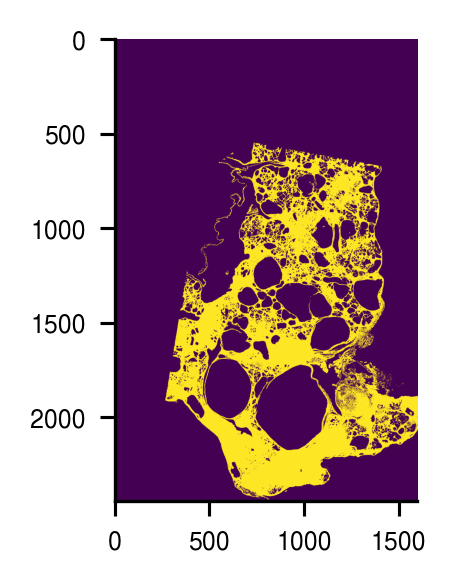

In [ ]:
fig, ax = plt.subplots(
    1, 1, figsize=(2,2)
)
ax.imshow(thumbnail[2] > thresh)

In [ ]:
levels = [1, 2, 3]
level = 2
not -len(levels) <= level < len(levels)

False

In [ ]:
import zarr

data_dir = Path(
    '/data1/peerd/spatial_datalake/reyesj3_pancreas_premalignant'
    '/15-07/processed'
)
tiff_path = next(data_dir.glob('microscopy/*warped*.tiff'))

store = tifffile.imread(
    tiff_path,
    aszarr=True,
    level=4,
)
z = zarr.open(store)

<tifffile.TiffFile '15-07_comet_bgs…_warped.ome.tiff'> OME series expected 15 frames, got 32
<tifffile.TiffFile '15-07_comet_bgs…_warped.ome.tiff'> OME series cannot handle discontiguous storage ((78136, 51134) != (44643, 44643))


In [ ]:
import zarr

data_dir = Path(
    '/data1/peerd/spatial_datalake/reyesj3_pancreas_premalignant'
    '/15-07/processed'
)
tiff_path = next(data_dir.glob('microscopy/*warped*.tiff'))

store = tifffile.imread(
    tiff_path,
    aszarr=True,
    level=5,
)
z = zarr.open(store)

<tifffile.TiffFile '15-07_comet_bgs…_warped.ome.tiff'> OME series expected 15 frames, got 32
<tifffile.TiffFile '15-07_comet_bgs…_warped.ome.tiff'> OME series cannot handle discontiguous storage ((78136, 51134) != (44643, 44643))


In [ ]:
import tifffile
import numpy as np
import zarr
import os
from collections import deque
from scipy.stats import mode

class QuadtreeNode:
    """A node in a Quadtree, representing a rectangular area."""
    def __init__(self, bounds, is_leaf=False, value=None):
        """
        Args:
            bounds (tuple): (y_min, x_min, y_max, x_max) for the node's area.
            is_leaf (bool): True if this is a leaf node.
            value (bool, np.ndarray, None):
                   - bool: True if foreground, False if background.
                   - np.ndarray: A dense bitmask for mixed-content leaves.
                   - None: For internal nodes that have children.
        """
        self.bounds = bounds
        self.is_leaf = is_leaf
        self.value = value
        self.children = []  # List of 4 child QuadtreeNodes

class OMETiffMask:
    """
    Creates a memory-efficient mask for a large OME-TIFF using a quadtree.

    This class builds a hierarchical quadtree representation of a tissue mask
    from a low-resolution level of a TIFF file. This allows for rapid queries
    to determine if a high-resolution coordinate is part of the foreground
    (tissue) or background.
    """

    def __init__(self,
                 tiff_path,
                 level=-1,
                 background_value=None,
                 max_background=0.95,
                 min_background=0.05,
                 min_leaf_size=100 * 100,
                 max_roots=4):
        """
        Initializes and builds the quadtree mask.

        Args:
            tiff_path (str): Path to the OME-TIFF file.
            level (int): The pyramid level to use for building the mask.
                         Default is -1 (the lowest resolution).
            background_value (list or np.ndarray, optional): A value for each
                channel that represents the background. If None, it will be
                auto-detected from the lowest resolution level.
            max_background (float): A tile with a background pixel ratio above
                this value will be marked as a background leaf (False).
            min_background (float): A tile with a background pixel ratio below
                this value will be marked as a foreground leaf (True).
            min_leaf_size (int): The smallest size (in pixels) for a quadtree
                leaf before it must store a dense mask.
            max_roots (int): The maximum number of root tiles to split the
                image into for building the tree.
        """
        self.tiff_path = tiff_path
        self.level = level
        self.min_leaf_size = min_leaf_size
        self.max_background_ratio = max_background
        self.min_background_ratio = min_background
        self.max_roots = max_roots

        if not os.path.exists(self.tiff_path):
            raise FileNotFoundError(f"TIFF file not found: {self.tiff_path}")

        with tifffile.TiffFile(self.tiff_path) as tif:
            self.full_res_shape = (tif.series[0].shape[0], tif.series[0].shape[1])
            self.level_zarr = zarr.open(tif.series[0].levels[self.level].aszarr())
            self.level_shape = self.level_zarr.shape
            self.scale_factor = self.full_res_shape[0] / self.level_shape[0]

        self.background_value = self._determine_background_value(background_value)
        self.roots = self._build_tree()

    def _determine_background_value(self, user_value):
        """Determines the background pixel value, either from user input or by auto-detection."""
        if user_value is not None:
            print(f"Using user-provided background value: {user_value}")
            return np.array(user_value)

        print("Auto-detecting background value from lowest resolution...")
        with tifffile.TiffFile(self.tiff_path) as tif:
            lowest_res = tif.series[0].levels[-1].asarray()
            # Find the most frequent value in each channel
            bg_value, _ = mode(lowest_res.reshape(-1, lowest_res.shape[-1]), axis=0)
            print(f"Auto-detected background value: {bg_value[0]}")
            return bg_value[0]

    def _build_tree(self):
        """Splits the low-res image into root tiles and builds a quadtree for each."""
        # Calculate tile size to be a power of 2
        max_dim = int(max(self.level_shape[0], self.level_shape[1]))
        num_tiles_edge = int(np.ceil(np.sqrt(self.max_roots)))
        tile_size = 1 << int((max_dim / num_tiles_edge)).bit_length()

        roots = []
        for y in range(0, self.level_shape[0], tile_size):
            for x in range(0, self.level_shape[1], tile_size):
                bounds = (y, x, y + tile_size, x + tile_size)
                root_node = self._build_recursive(bounds)
                roots.append(root_node)
        return roots

    def _build_recursive(self, bounds):
        """Recursively constructs the quadtree for a given area."""
        y_min, x_min, y_max, x_max = bounds
        height, width = y_max - y_min, x_max - x_min

        # Clip bounds to the actual image dimensions
        img_h, img_w = self.level_shape[:2]
        tile_data = self.level_zarr[y_min:min(y_max, img_h), x_min:min(x_max, img_w), :]

        if tile_data.size == 0:
            return QuadtreeNode(bounds, is_leaf=True, value=False) # Empty overhang

        # Check if any channel is different from background
        is_foreground_mask = np.any(tile_data != self.background_value, axis=2)
        foreground_ratio = np.sum(is_foreground_mask) / is_foreground_mask.size

        # a. Leaf if mostly foreground
        if foreground_ratio > (1.0 - self.min_background_ratio):
            return QuadtreeNode(bounds, is_leaf=True, value=True)
        # b. Leaf if mostly background
        if foreground_ratio < (1.0 - self.max_background_ratio):
            return QuadtreeNode(bounds, is_leaf=True, value=False)

        # c. Recurse if size allows
        if width > self.min_leaf_size and height > self.min_leaf_size:
            node = QuadtreeNode(bounds)
            y_mid, x_mid = y_min + height // 2, x_min + width // 2
            # Top-left
            node.children.append(self._build_recursive((y_min, x_min, y_mid, x_mid)))
            # Top-right
            node.children.append(self._build_recursive((y_min, x_mid, y_mid, x_max)))
            # Bottom-left
            node.children.append(self._build_recursive((y_mid, x_min, y_max, x_mid)))
            # Bottom-right
            node.children.append(self._build_recursive((y_mid, x_mid, y_max, x_max)))
            return node

        # d. Mixed leaf, store dense mask
        return QuadtreeNode(bounds, is_leaf=True, value=is_foreground_mask)

    def is_masked(self, y, x):
        """
        Checks if a coordinate at full resolution is masked (is foreground).

        Args:
            y (int): The y-coordinate at full resolution.
            x (int): The x-coordinate at full resolution.

        Returns:
            bool: True if the coordinate is considered foreground, False otherwise.
        """
        # Scale down to the level the tree was built on
        level_y = int(y / self.scale_factor)
        level_x = int(x / self.scale_factor)

        # Find the correct root node
        target_root = None
        for root in self.roots:
            ry_min, rx_min, ry_max, rx_max = root.bounds
            if ry_min <= level_y < ry_max and rx_min <= level_x < rx_max:
                target_root = root
                break
        
        if target_root is None:
            return False # Coordinate is outside any root tile

        # Traverse the tree
        node = target_root
        q = deque([node])
        while q:
            current_node = q.popleft()
            if current_node.is_leaf:
                if isinstance(current_node.value, bool):
                    return current_node.value
                else: # Dense mask lookup
                    y_min, x_min, _, _ = current_node.bounds
                    local_y, local_x = level_y - y_min, level_x - x_min
                    if 0 <= local_y < current_node.value.shape[0] and 0 <= local_x < current_node.value.shape[1]:
                        return current_node.value[local_y, local_x]
                    return False # Outside dense mask bounds
            
            # Find the correct child to descend into
            y_min, x_min, _, _ = current_node.bounds
            height, width = (current_node.bounds[2] - y_min), (current_node.bounds[3] - x_min)
            y_mid, x_mid = y_min + height // 2, x_min + width // 2
            
            child_idx = 0
            if level_y >= y_mid:
                child_idx += 2
            if level_x >= x_mid:
                child_idx += 1
            
            if child_idx < len(current_node.children):
                q.append(current_node.children[child_idx])

        return False # Should not be reached if tree is built correctly

In [ ]:
mask = OMETiffMask(tiff_path)

<tifffile.TiffFile '15-07_comet_bgs…_warped.ome.tiff'> OME series expected 15 frames, got 32
<tifffile.TiffFile '15-07_comet_bgs…_warped.ome.tiff'> OME series cannot handle discontiguous storage ((78136, 51134) != (44643, 44643))
<tifffile.TiffFile '15-07_comet_bgs…_warped.ome.tiff'> OME series expected 15 frames, got 32
<tifffile.TiffFile '15-07_comet_bgs…_warped.ome.tiff'> OME series cannot handle discontiguous storage ((78136, 51134) != (44643, 44643))


Auto-detecting background value from lowest resolution...
Auto-detected background value: 6


In [ ]:
mask.

np.False_

In [ ]:
z[:, :2**9, :2**9]

array([[[6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        ...,
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6]],

       [[6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        ...,
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6]],

       [[6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        ...,
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6]],

       ...,

       [[6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        ...,
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6]],

       [[6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        ...,
        [6, 6, 6, ..., 

In [ ]:
data_dir = Path(
    '/data1/peerd/spatial_datalake/reyesj3_pancreas_premalignant'
    '/15-07/processed'
)
tiff_path = next(data_dir.glob('microscopy/*warped*.tiff'))

In [ ]:
from tifffile import xml2dict, TiffFile
from ome_types import from_xml

In [ ]:
tf = TiffFile(tiff_path)
ome = from_xml(tf.ome_metadata)

In [ ]:
ome.images[0].pixels.planes

[Plane(
    the_z=0,
    the_t=0,
    the_c=3,
    exposure_time=25.0,
    exposure_time_unit='ms',
 ),
 Plane(
    the_z=0,
    the_t=0,
    the_c=1000,
    exposure_time=400.0,
    exposure_time_unit='ms',
 ),
 Plane(
    the_z=0,
    the_t=0,
    the_c=1001,
    exposure_time=400.0,
    exposure_time_unit='ms',
 ),
 Plane(
    the_z=0,
    the_t=0,
    the_c=1002,
    exposure_time=300.0,
    exposure_time_unit='ms',
 ),
 Plane(
    the_z=0,
    the_t=0,
    the_c=1003,
    exposure_time=400.0,
    exposure_time_unit='ms',
 ),
 Plane(
    the_z=0,
    the_t=0,
    the_c=1004,
    exposure_time=400.0,
    exposure_time_unit='ms',
 ),
 Plane(
    the_z=0,
    the_t=0,
    the_c=1005,
    exposure_time=400.0,
    exposure_time_unit='ms',
 ),
 Plane(
    the_z=0,
    the_t=0,
    the_c=1006,
    exposure_time=300.0,
    exposure_time_unit='ms',
 ),
 Plane(
    the_z=0,
    the_t=0,
    the_c=1007,
    exposure_time=300.0,
    exposure_time_unit='ms',
 ),
 Plane(
    the_z=0,
    the_t=0

In [ ]:
page = .pages[0]
for tag in page.tags.values():
    tag_name = tag.name
    tag_value = tag.value
    print(f"Tag Name: {tag_name}, Tag Value: {tag_value}")

Tag Name: ImageWidth, Tag Value: 51134
Tag Name: ImageLength, Tag Value: 78136
Tag Name: BitsPerSample, Tag Value: 16
Tag Name: Compression, Tag Value: 8
Tag Name: PhotometricInterpretation, Tag Value: 1
Tag Name: ImageDescription, Tag Value: <!-- Warning: this comment is an OME-XML metadata block, which contains crucial dimensional parameters and other important metadata. Please edit cautiously (if at all), and back up the original data before doing so. For more information, see the OME-TIFF web site: https://docs.openmicroscopy.org/latest/ome-model/ome-tiff/. --><OME xmlns="http://www.openmicroscopy.org/Schemas/OME/2016-06" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" Creator="Lunaphore Technologies SA" UUID="urn:uuid:df3460e7-fabe-46c0-bfb3-e1b9721c701b" xsi:schemaLocation="http://www.openmicroscopy.org/Schemas/OME/2016-06 http://www.openmicroscopy.org/Schemas/OME/2016-06/ome.xsd"><Experiment ID="Experiment:0" Type="Immunofluorescence"><Description>20250814_135105_2_bY909X_

In [ ]:
import zarr

data_dir = Path(
    '/data1/peerd/spatial_datalake/reyesj3_pancreas_premalignant'
    '/15-07/processed'
)
tiff_path = next(data_dir.glob('microscopy/*comet*warp*.tiff'))

store = tifffile.imread(
    tiff_path,
    aszarr=True,
    level=4,
)
z_wrp = zarr.open(store)

<tifffile.TiffFile '15-07_comet_bgs…_warped.ome.tiff'> OME series expected 15 frames, got 32
<tifffile.TiffFile '15-07_comet_bgs…_warped.ome.tiff'> OME series cannot handle discontiguous storage ((78136, 51134) != (44643, 44643))


In [ ]:
store = tifffile.imread(
    tiff_path,
    aszarr=True,
    level=4,
    selection=(0, slice(1000, 2000), slice(1000, 2000))
)
#z_wrp = zarr.open(store)

plt.imshow(store)

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

channels = [20, 22, -3]
x = 24000
y = 22000
w = 16 * 48

img = torch.tensor(z[channels, x:x+w, y:y+w]) / 4096

In [10]:
from dinov3.data.datasets.bioimage import BioImageDataset

ds = BioImageDataset(root=path_tiff_if, source_size=4096)

img = ds[50][0]

In [11]:
import numpy as np

img = np.subtract(img.T, means).T

/tmp/ipykernel_592248/3755914639.py:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4421.)
  img = np.subtract(img.T, means).T
/tmp/ipykernel_592248/3755914639.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img = np.subtract(img.T, means).T


In [12]:
import numpy as np

img = np.divide(img.T, std).T

/tmp/ipykernel_592248/1777739959.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img = np.divide(img.T, std).T


In [34]:
outs = model.teacher.backbone.get_intermediate_layers(
    img.unsqueeze(0).to(torch.float).to('cuda'),
)
emb = outs[-1].detach()[0]

In [35]:
from cuml.decomposition import PCA
from cuml.cluster import KMeans
from cuml.manifold import UMAP

In [36]:
w = ds._source_size
i = 1
j = 1
similarities = torch.cosine_similarity(
    emb[i * w // 16 + j],
    emb
)
similarities = similarities.reshape(w//16, w//16)

In [37]:
k = 15
l = 15
similarities_b = torch.cosine_similarity(
    emb[k * w // 16 + l],
    emb
)
similarities_b = similarities_b.reshape(w//16, w//16)

In [38]:
m = 30
n = 30
similarities_c = torch.cosine_similarity(
    emb[m * w // 16 + n],
    emb
)
similarities_c = similarities_c.reshape(w//16, w//16)

In [57]:
emb_pca = PCA().fit_transform(cp.array(emb))
clusters = KMeans(n_clusters=8).fit_predict(emb_pca[:, :])
clusters = clusters.reshape(w//16, w//16)
#emb_pca = emb_pca[:, 6].reshape(w//16, w//16)



[2025-08-25 17:24:32.270] [CUML] [warning] Warning(`fit`): As of v0.16, PCA invoked without an n_components argument defaults to using min(n_samples, n_features) rather than 1


In [58]:
umap = UMAP(min_dist=0.2, n_epochs=1000)
pos = umap.fit_transform(emb_pca).get()

[2025-08-25 17:24:32.348] [CUML] [info] Building knn graph using nn descent (configured from build_algo='auto')


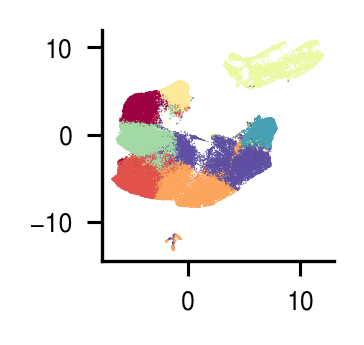

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(1,1))

ax.scatter(
    pos[:, 0], pos[:, 1],
    lw=0,
    s=.1,
    c=clusters.flatten().get(),
    cmap='Spectral'
)

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

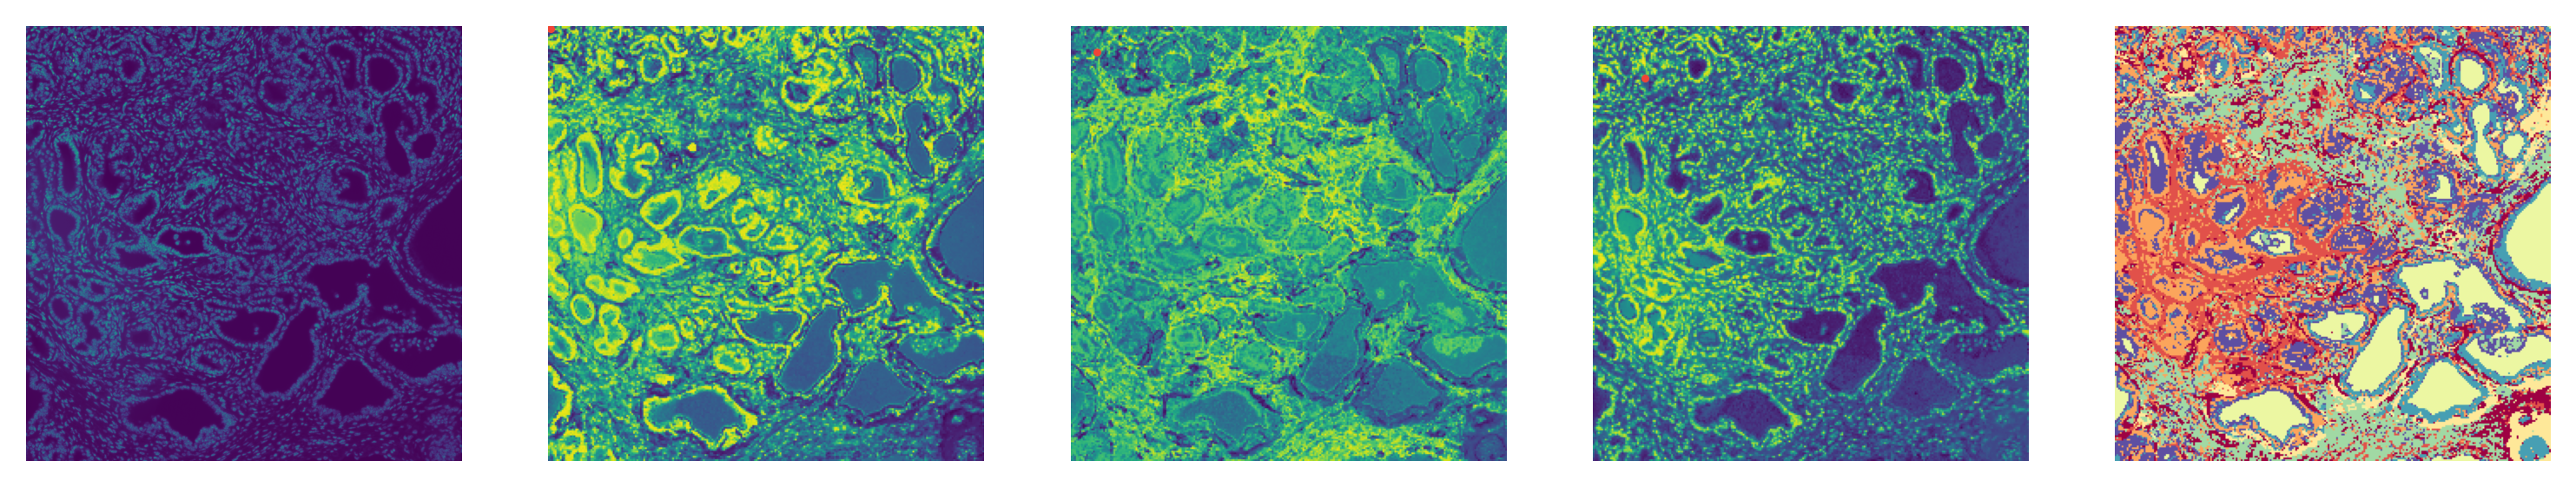

In [60]:
fig, axes = plt.subplots(1, 5, figsize=(12.5, 2.5))

axes[0].imshow(img[0]) #.swapaxes(0, -1))
axes[0].axis('off')

axes[1].imshow(similarities.cpu().numpy()) #.swapaxes(0, -1))
axes[1].scatter(i, j, s=2)
axes[1].axis('off')

axes[2].imshow(similarities_b.cpu().numpy()) #.swapaxes(0, -1))
axes[2].scatter(k, l, s=2)
axes[2].axis('off')

axes[3].imshow(similarities_c.cpu().numpy()) #.swapaxes(0, -1))
axes[3].scatter(m, n, s=2)
axes[3].axis('off')

axes[4].imshow(clusters.get(), cmap='Spectral') #.swapaxes(0, -1))
axes[4].scatter(m, n, s=2)
axes[4].axis('off')

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

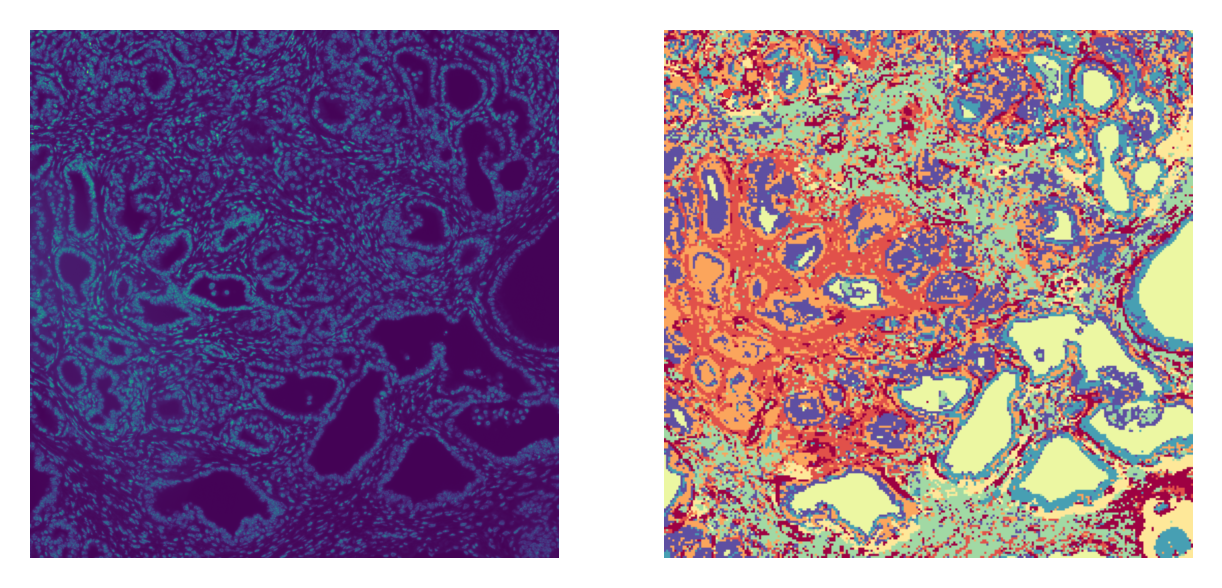

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(5, 2.5))

axes[0].imshow(img[0]) #.swapaxes(0, -1))
axes[0].axis('off')

axes[1].imshow(clusters.get(), cmap='Spectral') #.swapaxes(0, -1))
axes[1].scatter(m, n, s=2)
axes[1].axis('off')

In [22]:
img_rs = img.reshape(9, img.shape[1]//16, 16, img.shape[2]//16, 16)

In [23]:
img_rs.shape

torch.Size([9, 256, 16, 256, 16])

In [24]:
img_rs = img_rs.mean(axis=[2, 4])

In [27]:
emb.shape

torch.Size([65536, 384])

In [25]:
img_rs = img_rs.reshape(9, img_rs.shape[1] * img_rs.shape[2])

In [28]:
emb_pca = PCA().fit_transform(cp.array(img_rs).T)
clusters = KMeans(n_clusters=8).fit_predict(emb_pca[:, :])
clusters = clusters.reshape(w//16, w//16)
#emb_pca = emb_pca[:, 6].reshape(w//16, w//16)

[2025-08-25 17:13:21.888] [CUML] [warning] Warning(`fit`): As of v0.16, PCA invoked without an n_components argument defaults to using min(n_samples, n_features) rather than 1


In [29]:
umap = UMAP(min_dist=0.5, n_epochs=1000)
pos = umap.fit_transform(emb_pca).get()

[2025-08-25 17:13:25.958] [CUML] [info] Building knn graph using nn descent (configured from build_algo='auto')


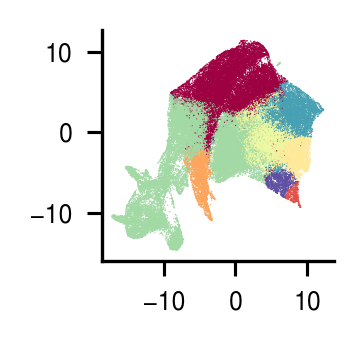

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(1,1))

ax.scatter(
    pos[:, 0], pos[:, 1],
    lw=0,
    s=.1,
    c=clusters.flatten().get(),
    cmap='Spectral'
)

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

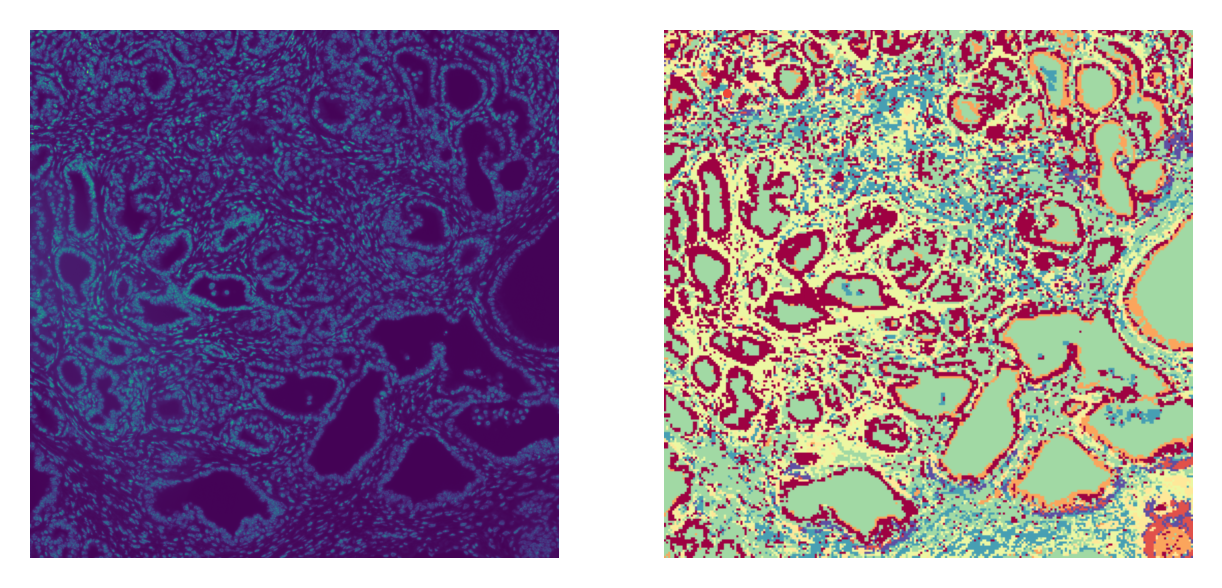

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(5, 2.5))

axes[0].imshow(img[0]) #.swapaxes(0, -1))
axes[0].axis('off')

axes[1].imshow(clusters.get(), cmap='Spectral') #.swapaxes(0, -1))
axes[1].scatter(m, n, s=2)
axes[1].axis('off')